In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from sklearn import preprocessing

path="Data//"

taux_interet =pd.read_csv('Data//taux_interet.csv',sep=',',parse_dates=['date'])
taux_endettement =pd.read_csv('Data//taux_endettement.csv',sep=',',)
parc=pd.read_csv(path+'parc_immobilier.csv',sep=',')

foyer_fiscaux=pd.read_csv(path+'foyers_fiscaux.csv',sep=',')

## Objectifs:

L'objectifs du modèle sera de faire des prédictions de prix de ventes des <b>appartements</b>.
On pourra effectuer ces prédictions à partir des informations suivantes:

Variable cible : prix

features: Quartier,Surface habitable carrez, n_pieces, Ancien/Neuf, 


Le marché de l'immobilier étant assez volatile, on realisera des prédiction en prenant une fenêtre de temps glissante à partir de la date de départ séléctionné par l'utilisateur.


## Macro structure:


IHM pour l'utilisateurs (Streamlit?) dans lequel on enverra:<ul>

<li>surface (intervalle)
<li>Neuf/ancien
<li>nb_pièces
<li>Diagnostic Performance Energétique
<li>Année de construction du batiment
</ul>

Sur la base de ces critères, on constitue une sous dataset pertinent pour effectuer une prédiction de type regression linéaire.


On renvoi cette prédiction à l'utilisateur.

## Transactions

In [3]:
# ---- /!\ A exécuter une fois /!\ ------------
arrays = dict(np.load("Data//transactions.npz"))

data = {k: [s.decode("utf-8") for s in v.tobytes().split(b"\x00")] if v.dtype == np.uint8 else v for k, v in arrays.items()}
transactions = pd.DataFrame.from_dict(data)

transactions=transactions[transactions['date_transaction']>dt.datetime(2018, 12, 31)]
transactions.to_csv('transactions_since_2019.csv',sep=',',index=False)
transactions=transactions[transactions['type_batiment']=='Appartement']

In [103]:
transactions =pd.read_csv('transactions_since_2019.csv',sep=',',parse_dates=['date_transaction'])

### Exemple sur Grenoble

In [3]:
#on prend les 1500 derniers transactions de Grenoble
transactions_gre=transactions[transactions['ville']=='GRENOBLE'].tail(1500)
transactions_gre.set_index('id_transaction',inplace=True)
transactions_gre['Q']=transactions_gre.date_transaction.apply(lambda x: x.to_period('Q'))

transactions_gre.head()

,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,surface_habitable,latitude,longitude
id_transaction,,,,,,,,,,,,,
3941778,2021-09-21,184000.0,38,185,GRENOBLE,38100,47 BD JOSEPH VALLIER,Appartement,False,4,63,45.179637,5.709171
3934656,2021-09-21,240000.0,38,185,GRENOBLE,38100,52 RUE DE STALINGRAD,Appartement,False,4,95,45.177927,5.724626
3940732,2021-09-21,147930.0,38,185,GRENOBLE,38100,26 RUE GAL FERRIE,Appartement,False,3,56,45.178138,5.723737
3957628,2021-09-21,168990.0,38,185,GRENOBLE,38000,15 PL GUSTAVE RIVET,Appartement,False,2,81,45.181512,5.727116
3952874,2021-09-21,110700.0,38,185,GRENOBLE,38100,14 PL LOUIS JOUVET,Appartement,False,4,82,45.170977,5.737585


### Prétraitement taux intéret

In [5]:
from sklearn import preprocessing
def preprocess_taux_interet(nom,path,profondeur): 

    #import
    taux_interet =pd.read_csv(path+nom,sep=',',parse_dates=['date'])
    #on supprime les valeurs na
    taux_interet=taux_interet[(~taux_interet['taux_10_20_ans'].isna())&(~taux_interet['taux_20_plus_ans'].isna())][['date','taux_10_20_ans','taux_20_plus_ans']]
    #on conservera que le crédit de 10 ans et plus
    taux_interet['taux moyen']=taux_interet.apply(lambda x: (x['taux_10_20_ans']+x['taux_20_plus_ans'])/2,axis=1)
    #extraction de l'année
    taux_interet['y']=taux_interet.date.apply(lambda x: x.year)
    #on filtre que les années les plus récentes
    taux_interet=taux_interet[taux_interet['y']>=(dt.date.today().year-profondeur)]
    
    #normalisation
    transformer = preprocessing.MinMaxScaler().fit(taux_interet[['taux moyen']])
    X_transformed = transformer.transform(taux_interet[['taux moyen']])
    temp=pd.DataFrame({'Taux_interet_norma': X_transformed[:,0]})
    taux_interet=pd.concat([taux_interet[['date','y']],temp],axis=1)
    taux_interet['Taux_interet_norma']=taux_interet['Taux_interet_norma'].apply(lambda x: round(x,3))

    taux_interet.sort_values(by=["date"],ascending=False,inplace=True)

    taux_interet['Q']=taux_interet.date.apply(lambda x:x.to_period('Q'))
    taux_interet=taux_interet[['Q','Taux_interet_norma']]
    return taux_interet

#jointure possible entre transactions et taux_interet

In [6]:
name_taux='taux_interet.csv'
taux_interet=preprocess_taux_interet(name_taux,path,3)


## Prétraitement logement vacant


In [11]:

def preprocess_logement_vac(nom,path): 

    year=dt.date.today().year
    
    #import
    parc=pd.read_csv(path+nom,sep=',')
    
    #supprimer les valeurs na
    parc=parc[(~parc['n_logements'].isna())&(~parc['n_logements_vacants'].isna())]
    
    #calculer le % d'occupation
    parc['perc_vacant']=parc.apply(lambda x: round(x['n_logements_vacants']/x['n_logements'],4)*100, axis=1)
    
    # les valeurs na sont remplacer par la moyenne du département
    parc_na=parc.groupby(['date','departement']).agg({'perc_vacant':'mean'}).reset_index()
    parc_na.rename(columns={'perc_vacant':'perc_vacant_na'},inplace=True)

    parc=parc.merge(parc_na,how='inner',on=['date','departement'])
    parc.perc_vacant.fillna(parc['perc_vacant_na'],inplace=True)

    parc=parc[['date','id_ville','ville','departement','perc_vacant']]
    
    return parc



In [12]:
parc_name='parc_immobilier.csv'
parc=preprocess_logement_vac(parc_name,path)


## Prétraitement Foyer fiscaux

In [16]:

def preprocess_Foyer_fiscaux(nom,path,profondeur):  
    year=dt.date.today().year
    #import
    foyer_fiscaux=pd.read_csv(path+nom,sep=',')
    
    #filtre sur les données inferieur à un certains nombre d'année
    foyer_fiscaux=foyer_fiscaux[foyer_fiscaux['date']>=year-(profondeur)]

    # les valeurs na sont remplacer par la moyenne du département
    foyer_fiscaux_na=foyer_fiscaux.groupby(['date','departement']).agg({'revenu_fiscal_moyen':'mean'}).reset_index()
    foyer_fiscaux_na=foyer_fiscaux_na.astype({'date':'int64','departement':str})

    foyer_fiscaux_na.rename(columns={'revenu_fiscal_moyen':'revenu_fiscal_moyen_na'},inplace=True)

    foyer_fiscaux_na.dtypes
    foyer_fiscaux=foyer_fiscaux.merge(foyer_fiscaux_na[['date','departement','revenu_fiscal_moyen_na']],how='inner',on=['date','departement'])
    foyer_fiscaux.revenu_fiscal_moyen.fillna(foyer_fiscaux['revenu_fiscal_moyen_na'],inplace=True)
    foyer_fiscaux=foyer_fiscaux[['date','id_ville','ville','departement','revenu_fiscal_moyen']]

    return foyer_fiscaux


In [17]:
foyer_fiscaux_name='foyers_fiscaux.csv'

foyer_fiscaux=preprocess_Foyer_fiscaux(foyer_fiscaux_name,path,3)

## Exemple sur un sous dataset : Grenoble

In [18]:
#compilation du dataset final

transactions_gre['departement']=transactions_gre.departement.astype(str)
final=transactions_gre.merge(foyer_fiscaux[['id_ville','departement','revenu_fiscal_moyen']],how='left',on=['departement','id_ville']).merge(parc[['id_ville','departement','perc_vacant']],how='left',on=['departement','id_ville']).merge(taux_interet[['Q','Taux_interet_norma']],how='left',on='Q')
final.sort_values(by='date_transaction',ascending=False,inplace=True)
final.head()

,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,n_pieces,surface_habitable,latitude,longitude,Q,revenu_fiscal_moyen,perc_vacant,Taux_interet_norma
0,2021-09-21,184000.0,38,185,GRENOBLE,38100,47 BD JOSEPH VALLIER,Appartement,False,4,63,45.179637,5.709171,2021Q3,24238.12,12.94,0.0
1,2021-09-21,240000.0,38,185,GRENOBLE,38100,52 RUE DE STALINGRAD,Appartement,False,4,95,45.177927,5.724626,2021Q3,24238.12,12.94,0.0
2,2021-09-21,147930.0,38,185,GRENOBLE,38100,26 RUE GAL FERRIE,Appartement,False,3,56,45.178138,5.723737,2021Q3,24238.12,12.94,0.0
3,2021-09-21,168990.0,38,185,GRENOBLE,38000,15 PL GUSTAVE RIVET,Appartement,False,2,81,45.181512,5.727116,2021Q3,24238.12,12.94,0.0
4,2021-09-21,110700.0,38,185,GRENOBLE,38100,14 PL LOUIS JOUVET,Appartement,False,4,82,45.170977,5.737585,2021Q3,24238.12,12.94,0.0


## IRIS code
on va déterminer l'IRIS Code grâce à la position GPS (latitude et longitude).


On utilise une API mis à disposition pour obtenir l'IRIS CODE: https://pyris.datajazz.io/doc/

On pourra par la suite réaliser des prédictions sur le quartier (=IRIS CODE) associé au bien que l'utilisateur souhaite estimer


In [52]:
import requests
def get_IRIS_CODE_FROM_LAT_LONG(lat,long):  

    lat=str(lat)
    long=str(long)
    r = requests.get('https://pyris.datajazz.io/api/coords?geojson=false&lat='+lat+'&lon='+long+'')
    status_code = r.status_code
    
    if(status_code==200):    
        response_dict = r.json()
        code=response_dict['complete_code']+'/'+response_dict['city']+'_'+response_dict['name']
    else:
        code=None   

    return code


In [29]:
final['IRIS_CODE']=final.apply(lambda x: None if (pd.isna(x['latitude']) | pd.isna(x['longitude'])) else get_IRIS_CODE_FROM_LAT_LONG(x['latitude'],x['longitude']),axis=1)
final['Quartier']=final.IRIS_CODE.apply(lambda x: x.split('/')[1])
final['IRIS_CODE']=final.IRIS_CODE.apply(lambda x: x.split('/')[0])


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


C:\Users\VLAGO\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
final.Quartier.value_counts(normalize=True)

#on fait le choix de prendre le quartier Championnet

Grenoble_Vigny-Musset         0.058
Grenoble_Championnet          0.043
Grenoble_Gabriel Peri         0.030
Grenoble_Foch Ouest           0.026
Grenoble_Peretto              0.024
                              ...  
Grenoble_Paul Cocat           0.004
Grenoble_Constantine          0.004
Grenoble_Hebert-Mutualite     0.003
Grenoble_Jouhaux              0.001
Grenoble_Helbronner-Geants    0.001
Name: Quartier, Length: 64, dtype: float64

In [ ]:
#Test quartier Championnet de Grenoble
transactions_gre_champ=final_gre[(final_gre['Quartier']=='Grenoble_Championnet')]

#transactions_gre_champ.to_csv('transactions_gre_IRIS.csv',sep=';',index=False)

## Modélisation


Algorithme à tester:<ul>
<li>regression lineaire
<li>random forest regressor
<li>support vector
</ul>

    
Metrique à utiliser:<ul>
<li>mean absolute error
<li>median absolute error
</ul>


Le choix de la métrique peut être à ajuster si la dispersion est trés importante sur le sous dataset:<ul>
    <li>mean absolute error lorsque faible dispersion (à définir)
    <li>median absolute error lorsque la dispersion est forte (à définir)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


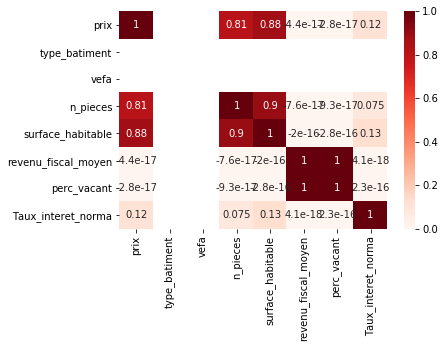

In [96]:
transac_gre_champ=pd.read_csv('transactions_gre_IRIS.csv',sep=';')
X=transac_gre_champ.drop(['date_transaction','departement','id_ville','code_postal','ville','departement','adresse','latitude','longitude','Q','IRIS_CODE','Quartier'],axis=1)
X = X.replace({"Appartement":0, "Maison":1})
X["vefa"] = X["vefa"].astype(int)

sns.heatmap(X.corr(), annot=True, cmap='Reds')

#Sans surprise, on voit une forte corrélation prix / surface 

In [97]:
#Séparation cible et features
y=X.prix
X=X.drop(['prix'],axis=1)

In [99]:
def perf_prix (X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    mae=-1
    med=-1
    
    for m in model:
        m.fit(X_train,y_train)
        pred=m.predict(X_test)
        mae_temp=mean_absolute_error(pred,y_test)
        #med_temp=median_absolute_error(pred,y_test)
        
        if ((mae ==-1) | (mae_temp<mae)):
            mae=mae_temp
            best_model=m
        
    return mae,best_model

In [100]:
model_reg=[]

svr = SVR(kernel='rbf')
knn= KNeighborsRegressor(n_neighbors=10)
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth=2, random_state=0)


model_reg.append(svr)
model_reg.append(knn)
model_reg.append(lr)
model_reg.append(rfr)

print('La meilleur performance a une erreur absolue moyenne de :',perf_prix(X,y,model_reg)[0])

print('Le meilleur estimateur est: ',type(perf_prix(X_test,y_test,model_reg)[1]))

La meilleur performance a une erreur absolue moyenne de : 42860.595473236506
Le meilleur estimateur est:  <class 'sklearn.linear_model._base.LinearRegression'>
